# IMDB Movie Review Classification

Fine tune BERT to perform sentiment analysis on dataset of plain-text IMDB movie reviews.

In [21]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as tfh
import tensorflow_text as tfx # Important for processor
import matplotlib.pyplot as plt

tf.__version__

'2.7.0'

In [2]:
# tf.keras.backend.set_floatx("float32")

## Prepare data

In [3]:
# Load data
train_dataset, test_dataset = tfds.load(
    name="imdb_reviews",
    as_supervised=True,
    split=('train', 'test'),
    data_dir="/database/tensorflow-datasets/"
)

2021-12-12 19:26:37.144871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 19:26:37.148718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 19:26:37.149184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 19:26:37.150479: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
for review, label in train_dataset.take(1).as_numpy_iterator():
    print("Review;", review, "Label:", label)

Review; b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it." Label: 0


2021-12-12 19:26:37.789105: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
for review, label in test_dataset.take(1).as_numpy_iterator():
    print("Review;", review, "Label:", label)

Review; b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come." Label: 1


2021-12-12 19:26:37.843554: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Choose model

In [6]:
os.listdir("/modelbase/BERT/")

['bert_en_uncased_L-12_H-768_A-12_4',
 'small_bert_bert_en_uncased_L-12_H-128_A-2_2',
 'bert_en_uncased_preprocess_3',
 'small_bert_bert_en_uncased_L-4_H-512_A-8_2']

In [7]:
BERT_MODEL = "small_bert_bert_en_uncased_L-4_H-512_A-8_2"
PROCESSOR = "bert_en_uncased_preprocess_3"

In [8]:
# Create an optimized dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

## Using processor

In [9]:
bert_preprocessor = tfh.KerasLayer(f"/modelbase/BERT/{PROCESSOR}", name="text_processor")

In [10]:
text_preprocessed = bert_preprocessor(["this is such an amazing movie!"])

print(f"Keys       : {list(text_preprocessed.keys())}")
print(f"Shape      : {text_preprocessed['input_word_ids'].shape}")
print(f"Word Ids   : {text_preprocessed['input_word_ids'][0, :12]}")
print(f"Input Mask : {text_preprocessed['input_mask'][0, :12]}")
print(f"Type Ids   : {text_preprocessed['input_type_ids'][0, :12]}")

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (input_words_id, input_mask and input_type_ids).

Some other important points:

- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the Solve GLUE tasks using BERT on a TPU colab.
- The input_type_ids only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using bert model

In [11]:
bert_model = tfh.KerasLayer(f"/modelbase/BERT/{BERT_MODEL}", trainable=True, name="bert_model")

In [12]:
bert_results = bert_model(text_preprocessed)

print(f"Pooled Outputs Shape:{bert_results['pooled_output'].shape}")
print(f"Pooled Outputs Values:{bert_results['pooled_output'][0, :12]}")
print(f"Sequence Outputs Shape:{bert_results['sequence_output'].shape}")
print(f"Sequence Outputs Values:{bert_results['sequence_output'][0, :12]}")

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626286   0.99280983 -0.1861189   0.36673835  0.15233701  0.65504444
  0.9681153  -0.948627    0.00216158 -0.9877732   0.06842719 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946322  0.3432122   0.33231512 ...  0.2130085   0.7102077
  -0.05771145]
 [-0.28742045  0.31981018 -0.2301861  ...  0.58455044 -0.21329743
   0.7269206 ]
 [-0.6615702   0.68876827 -0.8743304  ...  0.10877316 -0.26173204
   0.47855455]
 ...
 [-0.22561158 -0.28925583 -0.07064367 ...  0.47566044  0.83277196
   0.40025324]
 [-0.298242   -0.27473158 -0.05450519 ...  0.48849782  1.0955359
   0.1816341 ]
 [-0.44378144  0.00930715  0.07223722 ...  0.17290151  1.1833243
   0.07898054]]


The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

- pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.
- sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.
- encoder_outputs are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.

For the fine-tuning you are going to use the pooled_output array.

## Implement model

In [13]:
# Define model input
model_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_text")

# Preprocess text
encoder_input = bert_preprocessor(model_input)

# Get embedddings
encoded = bert_model(encoder_input)

# Define classifier
net = encoded["pooled_output"]
net = tf.keras.layers.Dropout(0.1)(net)
model_output = tf.keras.layers.Dense(1, activation=None, name="classifier")(net)

# Create new model
final_bert_model = tf.keras.Model(model_input, model_output)

In [14]:
results = final_bert_model(tf.constant(["this is such an amazing movie!"]))
print(tf.sigmoid(results))

tf.Tensor([[0.84734863]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

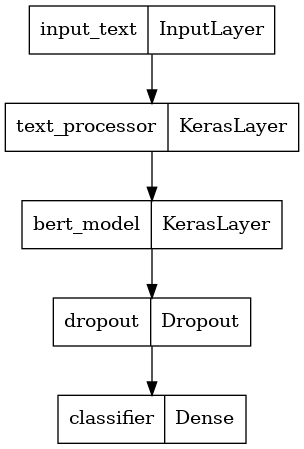

In [15]:
tf.keras.utils.plot_model(final_bert_model)

In [16]:
final_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 text_processor (KerasLayer)    {'input_type_ids':   0           ['input_text[0][0]']             
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

## Learn and evaluate

In [17]:
# Set loss and metrics
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.keras.metrics.BinaryAccuracy()

# Set optimizer
optimizer = tf.keras.optimizers.Adam(amsgrad=True, learning_rate=5e-5)

In [18]:
# Compile model
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs

final_bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics, steps_per_execution=num_train_steps)

In [19]:
# Adapt bert model to new data
history = final_bert_model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, verbose=True)

Epoch 1/5
782/782 [==============================] - 142s 182ms/step - loss: 0.4138 - binary_accuracy: 0.7986 - val_loss: 0.3351 - val_binary_accuracy: 0.8458
Epoch 2/5
782/782 [==============================] - 137s 175ms/step - loss: 0.2763 - binary_accuracy: 0.8796 - val_loss: 0.4006 - val_binary_accuracy: 0.8500
Epoch 3/5
782/782 [==============================] - 137s 175ms/step - loss: 0.1818 - binary_accuracy: 0.9276 - val_loss: 0.4674 - val_binary_accuracy: 0.8467
Epoch 4/5
782/782 [==============================] - 137s 175ms/step - loss: 0.1250 - binary_accuracy: 0.9512 - val_loss: 0.5943 - val_binary_accuracy: 0.8447
Epoch 5/5
782/782 [==============================] - 137s 175ms/step - loss: 0.0694 - binary_accuracy: 0.9752 - val_loss: 0.6717 - val_binary_accuracy: 0.8328


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


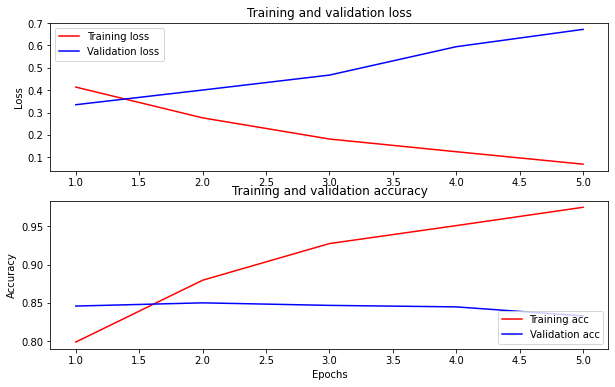

In [22]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, "r", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
# plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

## Export tuned model

In [24]:
os.listdir("/modelbase/")

['MuRIL', 'BERT', 'USE']

In [29]:
saved_model_path = f"/modelbase/BERT/{BERT_MODEL}_sentiment_en_imdb"
saved_model_path

'/modelbase/BERT/small_bert_bert_en_uncased_L-4_H-512_A-8_2_sentiment_en_imdb'

In [30]:
final_bert_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /modelbase/BERT/small_bert_bert_en_uncased_L-4_H-512_A-8_2_sentiment_en_imdb/assets


INFO:tensorflow:Assets written to: /modelbase/BERT/small_bert_bert_en_uncased_L-4_H-512_A-8_2_sentiment_en_imdb/assets


In [1]:
os.listdir("/modelbase/BERT/")

['bert_en_uncased_L-12_H-768_A-12_4',
 'small_bert_bert_en_uncased_L-12_H-128_A-2_2',
 'small_bert_bert_en_uncased_L-4_H-512_A-8_2_sentiment_en_imdb',
 'bert_en_uncased_preprocess_3',
 'small_bert_bert_en_uncased_L-4_H-512_A-8_2']

In [34]:
examples = [
	"this is such an amazing movie!",  # this is the same sentence tried earlier
    "The movie was great!",
    "The movie was meh.",
    "The movie was okish.",
    "The movie was terrible..."
]

In [37]:
def print_my_examples(inputs, results):
	result_for_printing = [f"input: {inputs[i]:<30} : score: {results[i][0]:.6f}" for i in range(len(inputs))]
	print(*result_for_printing, sep="\n")
	print()

results = tf.sigmoid(final_bert_model(tf.constant(examples)))
print_my_examples(examples, results)

input: this is such an amazing movie! : score: 0.999618
input: The movie was great!           : score: 0.990734
input: The movie was meh.             : score: 0.979488
input: The movie was okish.           : score: 0.000229
input: The movie was terrible...      : score: 0.000122

